## Проверим включен ли GPU 

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8460471085648976217
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3132581478
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7932938506429397077
physical_device_desc: "device: 0, name: GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import scipy.io
import tarfile
import csv
import sys
import os


from ImageDataAugmentor.image_data_augmentor import *
import albumentations
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import tensorflow.keras.callbacks as C
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras import optimizers
import efficientnet.tfkeras as efn
import zipfile

#from ImageDataAugmentor.image_data_augmentor import *
#import albumentations

from sklearn.model_selection import train_test_split

import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline


os.environ["CUDA_VISIBLE_DEVICES"] = "0"

print(os.listdir("input"))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

['sample-submission.csv', 'test.zip', 'train.csv', 'train.zip']
Python       : 3.7.4 (default, Aug  9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]
Numpy        : 1.19.5
Tensorflow   : 2.4.1
Keras        : 2.4.0


# Зададим все параметры для дальнейшей работы 

In [3]:
EPOCHS_1               = 10  # эпох на обучение
EPOCHS_2               = 10  # эпох на обучение
EPOCHS_3               = 5  # эпох на обучение
EPOCHS_4               = 5  # эпох на обучение

BATCH_SIZE_1           = 16 # уменьшаем batch если сеть большая, иначе не поместится в память на GPU
BATCH_SIZE_2           = 8 # уменьшаем batch если сеть большая, иначе не поместится в память на GPU
BATCH_SIZE_3           = 2 # уменьшаем batch если сеть большая, иначе не поместится в память на GPU
BATCH_SIZE_4           = 2 # уменьшаем batch если сеть большая, иначе не поместится в память на GPU
LR                   = 1e-3

VAL_SPLIT            = 0.20 # сколько данных выделяем на тест = 15%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 250 # какого размера подаем изображения в сеть
IMG_SIZE_             = 350 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)
RANDOM_SEED          = 42

DATA_PATH = 'input/'
PATH = "working/car/" # рабочая директория

#  EDA (Разведывательный анализ данных)

In [4]:
train_df = pd.read_csv(DATA_PATH+"train.csv")
sample_submission = pd.read_csv(DATA_PATH+"sample-submission.csv")
train_df.head()

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
Id          15561 non-null object
Category    15561 non-null int64
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


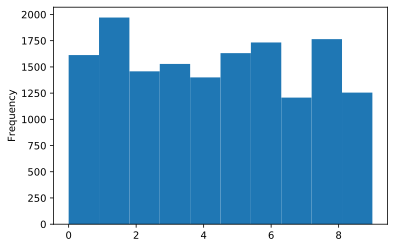

In [6]:
train_df.Category.plot(kind="hist")

### Распределение классов достаточно равномерное — это хорошо.

### Посмотрим на примеры картинок и их размеры, чтобы понимать, как их лучше обрабатывать и сжимать.

Пример картинок (random sample)


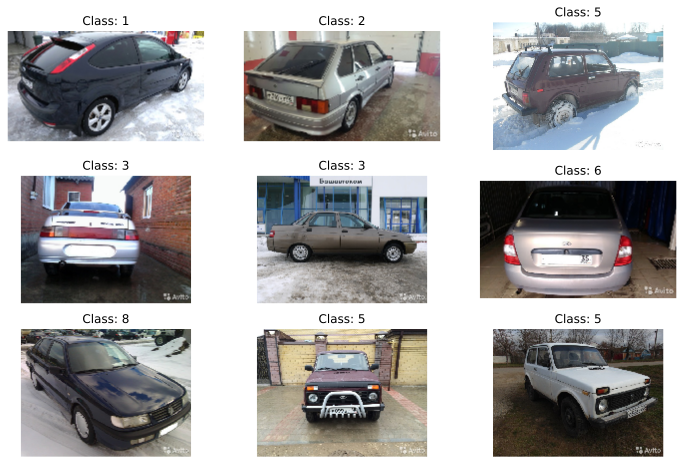

In [34]:
print('Пример картинок (random sample)')
plt.figure(figsize=(12,8))

random_image = train_df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(PATH+f'train/{random_image_cat[index]}/{path}')
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

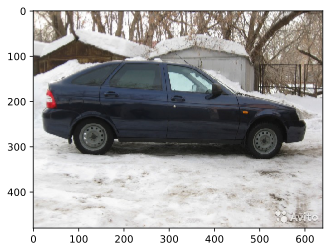

(640, 480)

In [35]:
image = PIL.Image.open(PATH+'/train/0/100380.jpg')
imgplot = plt.imshow(image)
plt.show()
image.size

Видим, что классы указывают на модели автомобилей ВАЗ, также присутствуют Ford Focus и Volkswagen Passat

## АУГМЕНТАЦИЯ ДАННЫХ

Пробовал использовать библиотеку ImageDataAugmentor, но не получил каких то улучшенных результатов 

In [36]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=VAL_SPLIT, # set validation split
    horizontal_flip=False)

test_datagen = ImageDataGenerator(rescale=1. / 255)

## ГЕНЕРАЦИЯ ДАННЫХ

Завернём наши данные в генератор.

In [37]:
train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data


Found 12452 images belonging to 10 classes.
Found 3109 images belonging to 10 classes.


## Строим модель

Загружаем предобученную сеть Xception

In [38]:
input_shape

(250, 250, 3)

В качестве базовой модели использовал EfficientNetB0, EfficientNetB3, EfficientNetB4, EfficientNetB7  
##### Наилучший результат показал EfficientNetB6

In [7]:
base_model = efn.EfficientNetB6(weights='imagenet', include_top=False, input_shape=input_shape)

# Для начала заморозим веса EfficientNetB6 и обучим только "голову". 
# Делаем это для того, чтобы хорошо обученные признаки на Imagenet не затирались в самом начале нашего обучения
base_model.trainable = False
# Устанавливаем новую "голову" (head)

model=M.Sequential()
model.add(base_model)
model.add(L.GlobalAveragePooling2D(),) # объединяем все признаки в единый вектор 

# Экспериментируем с архитектурой - добавляем ещё один полносвязный слой, dropout и batch-нормализацию
model.add(L.Dense(256, activation='relu'))
model.add(L.BatchNormalization())
model.add(L.Dropout(0.25))
model.add(L.Dense(CLASS_NUM, activation='softmax'))



In [40]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b6 (Functional) (None, 8, 8, 2304)        40960136  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2304)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               590080    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2570      
Total params: 41,553,810
Trainable params: 593,162
Non-trainable params: 40,960,648
____________________________________

## Обучаем модель

#### Без использования One Cycle Policy, не удалось поднять score выше ~70%

# Управление Learning Rate - One Cycle Policy

In [41]:
class CyclicLR(keras.callbacks.Callback):
    
    def __init__(self,base_lr, max_lr, step_size, base_m, max_m, cyclical_momentum):
 
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.base_m = base_m
        self.max_m = max_m
        self.cyclical_momentum = cyclical_momentum
        self.step_size = step_size
        
        self.clr_iterations = 0.
        self.cm_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}
        
    def clr(self):
        
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        
        if cycle == 2:
            x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)          
            return self.base_lr-(self.base_lr-self.base_lr/100)*np.maximum(0,(1-x))
        
        else:
            x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0,(1-x))
    
    def cm(self):
        
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        
        if cycle == 2:
            
            x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1) 
            return self.max_m
        
        else:
            x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
            return self.max_m - (self.max_m-self.base_m)*np.maximum(0,(1-x))
        
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())
            
        if self.cyclical_momentum == True:
            if self.clr_iterations == 0:
                K.set_value(self.model.optimizer.momentum, self.cm())
            else:
                K.set_value(self.model.optimizer.momentum, self.cm())
            
            
    def on_batch_begin(self, batch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)
        
        if self.cyclical_momentum == True:
            self.history.setdefault('momentum', []).append(K.get_value(self.model.optimizer.momentum))

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())
        
        if self.cyclical_momentum == True:
            K.set_value(self.model.optimizer.momentum, self.cm())

## Обучаем 

In [42]:
# Learning Rate One Cycle Policy
MAX_MOMENTUM = 0.98
BASE_MOMENTUM = 0.85
CYCLICAL_MOMENTUM = True
AUGMENT = True
CYCLES = 2.35

# Настройки
batch_size = BATCH_SIZE
epochs = 10
base_lr = 1e-3
max_lr = base_lr*10
max_m = MAX_MOMENTUM
base_m = BASE_MOMENTUM

cyclical_momentum = CYCLICAL_MOMENTUM
augment = AUGMENT
cycles = CYCLES

# Расчет количества итерация и шага изменения learning rate
iterations = round(train_generator.samples//train_generator.batch_size*epochs)
iterations = list(range(0,iterations+1))
step_size = len(iterations)/(cycles)

model.compile(loss="categorical_crossentropy", optimizer=optimizers.SGD(lr=base_lr, momentum=BASE_MOMENTUM), metrics=["accuracy"])

clr =  CyclicLR(
    base_lr=base_lr,
    max_lr=max_lr,
    step_size=step_size,
    max_m=max_m,
    base_m=base_m,
    cyclical_momentum=cyclical_momentum
)
    
# Добавим ModelCheckpoint чтоб сохранять прогресс обучения модели и можно было потом подгрузить и дообучить модель.    
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['accuracy'] , verbose = 1  , mode = 'max')
earlystop = EarlyStopping(monitor='accuracy', patience=5, restore_best_weights=True)
callbacks_list = [checkpoint, earlystop, clr]


In [43]:
history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        validation_data = test_generator, 
        validation_steps = test_generator.samples//test_generator.batch_size,
        epochs = epochs,
        callbacks = callbacks_list
)

Epoch 1/10
1556/1556 [==============================] - 536s 332ms/step - loss: 1.8666 - accuracy: 0.3719 - val_loss: 1.0704 - val_accuracy: 0.6160

Epoch 00001: saving model to best_model.hdf5
Epoch 2/10
1556/1556 [==============================] - 527s 339ms/step - loss: 1.4360 - accuracy: 0.4961 - val_loss: 0.8955 - val_accuracy: 0.6807

Epoch 00002: saving model to best_model.hdf5
Epoch 3/10
1556/1556 [==============================] - 528s 339ms/step - loss: 1.2985 - accuracy: 0.5357 - val_loss: 0.8317 - val_accuracy: 0.7026

Epoch 00003: saving model to best_model.hdf5
Epoch 4/10
1556/1556 [==============================] - 528s 339ms/step - loss: 1.2005 - accuracy: 0.5756 - val_loss: 0.8521 - val_accuracy: 0.6927

Epoch 00004: saving model to best_model.hdf5
Epoch 5/10
1556/1556 [==============================] - 527s 339ms/step - loss: 1.1766 - accuracy: 0.5843 - val_loss: 0.7839 - val_accuracy: 0.7204

Epoch 00005: saving model to best_model.hdf5
Epoch 6/10
1556/1556 [========

#### Сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model):

In [44]:
model.save('working/model_last.hdf5')
model.load_weights('best_model.hdf5')

In [45]:
scores = model.evaluate(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

389/389 [==============================] - 102s 261ms/step - loss: 0.6700 - accuracy: 0.7626
Accuracy: 76.26%


### Посмотрим на графики обучения:

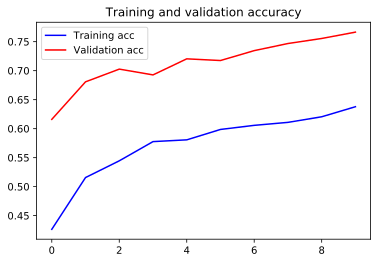

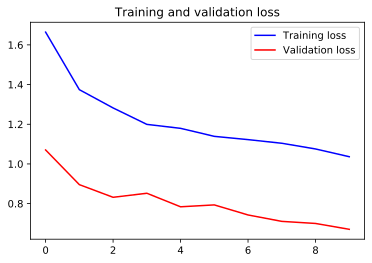

In [51]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

#  FineTuning - обучение половины весов EfficientNetb7

In [52]:
print("Количество слоев в базовой модели: ", len(base_model.layers))

Количество слоев в базовой модели:  659


In [53]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = len(base_model.layers)//2

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [54]:
len(base_model.trainable_variables)

291

In [55]:
# Check the trainable status of the individual layers
for layer in model.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.functional.Functional object at 0x0000022AB818F8C8> True
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x0000022AB817E548> True
<tensorflow.python.keras.layers.core.Dense object at 0x0000022ABD717C48> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x0000022AB81841C8> True
<tensorflow.python.keras.layers.core.Dropout object at 0x0000022ABD7DC308> True
<tensorflow.python.keras.layers.core.Dense object at 0x0000022ABD44CFC8> True


In [56]:
# Настройки
#batch_si10
base_lr = 1e-4
max_lr = base_lr*10
#max_m = MAX_MOMENTUM
#base_m = BASE_MOMENTUM

#cyclical_momentum = CYCLICAL_MOMENTUM
#augment = AUGMENT
#cycles = CYCLES

# Расчет количества итерация и шага изменения learning rate
iterations = round(train_generator.samples//train_generator.batch_size*10)
iterations = list(range(0,iterations+1))
step_size = len(iterations)/(cycles)

model.compile(loss="categorical_crossentropy", 
              optimizer=optimizers.SGD(lr=base_lr, momentum=BASE_MOMENTUM), 
              metrics=["accuracy"])


clr =  CyclicLR(
    base_lr=base_lr,
    max_lr=max_lr,
    step_size=step_size,
    max_m=max_m,
    base_m=base_m,
    cyclical_momentum=cyclical_momentum
)
    
# Добавим ModelCheckpoint чтоб сохранять прогресс обучения модели и можно было потом подгрузить и дообучить модель.    
#checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')
#earlystop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
callbacks_list = [checkpoint, earlystop, clr]
# Обучаем
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples//train_generator.batch_size,
    validation_data = test_generator, 
    validation_steps = test_generator.samples//test_generator.batch_size,
    epochs = 10,
    callbacks = callbacks_list
)

Epoch 1/10
1556/1556 [==============================] - 1068s 670ms/step - loss: 1.5354 - accuracy: 0.5136 - val_loss: 0.4635 - val_accuracy: 0.8360

Epoch 00001: saving model to best_model.hdf5
Epoch 2/10
1556/1556 [==============================] - 1140s 733ms/step - loss: 0.6964 - accuracy: 0.7566 - val_loss: 0.3142 - val_accuracy: 0.8908

Epoch 00002: saving model to best_model.hdf5
Epoch 3/10
1556/1556 [==============================] - 1230s 791ms/step - loss: 0.5331 - accuracy: 0.8052 - val_loss: 0.2737 - val_accuracy: 0.9027

Epoch 00003: saving model to best_model.hdf5
Epoch 4/10
1556/1556 [==============================] - 1159s 745ms/step - loss: 0.4408 - accuracy: 0.8481 - val_loss: 0.2340 - val_accuracy: 0.9185

Epoch 00004: saving model to best_model.hdf5
Epoch 5/10
1556/1556 [==============================] - 1023s 657ms/step - loss: 0.3616 - accuracy: 0.8753 - val_loss: 0.2078 - val_accuracy: 0.9201

Epoch 00005: saving model to best_model.hdf5
Epoch 6/10
1556/1556 [===

In [57]:
model.save('../working/model_step3.hdf5')
model.load_weights('best_model.hdf5')

In [58]:
scores = model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

C:\Users\Stark\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


389/389 [==============================] - 101s 260ms/step - loss: 0.1737 - accuracy: 0.9389
Accuracy: 93.89%


# Step 3 - FineTuning - разморозка всей сети EfficientNetB6 и дообучение

In [59]:
BATCH_SIZE           = 2

In [60]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=VAL_SPLIT, # set validation split
    horizontal_flip=False)

test_datagen = ImageDataGenerator(rescale=1. / 255)

In [61]:
train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data


Found 12452 images belonging to 10 classes.
Found 3109 images belonging to 10 classes.


In [62]:
base_model.trainable = True

In [63]:
# Настройки
#batch_si10
base_lr = 1e-4
max_lr = base_lr*10
#max_m = MAX_MOMENTUM
#base_m = BASE_MOMENTUM

#cyclical_momentum = CYCLICAL_MOMENTUM
#augment = AUGMENT
#cycles = CYCLES

# Расчет количества итерация и шага изменения learning rate
iterations = round(train_generator.samples//train_generator.batch_size*4)
iterations = list(range(0,iterations+1))
step_size = len(iterations)/(cycles)

model.compile(loss="categorical_crossentropy", 
              optimizer=optimizers.SGD(lr=base_lr, momentum=BASE_MOMENTUM), 
              metrics=["accuracy"])


clr =  CyclicLR(
    base_lr=base_lr,
    max_lr=max_lr,
    step_size=step_size,
    max_m=max_m,
    base_m=base_m,
    cyclical_momentum=cyclical_momentum
)
    
# Добавим ModelCheckpoint чтоб сохранять прогресс обучения модели и можно было потом подгрузить и дообучить модель.    
#checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')
#earlystop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
callbacks_list = [checkpoint, earlystop, clr]
# Обучаем
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples//train_generator.batch_size,
    validation_data = test_generator, 
    validation_steps = test_generator.samples//test_generator.batch_size,
    epochs = 4,
    callbacks = callbacks_list
)

Epoch 1/4
6226/6226 [==============================] - 2987s 476ms/step - loss: 1.1085 - accuracy: 0.6893 - val_loss: 0.2687 - val_accuracy: 0.9263

Epoch 00001: saving model to best_model.hdf5
Epoch 2/4
6226/6226 [==============================] - 3542s 569ms/step - loss: 0.8316 - accuracy: 0.7849 - val_loss: 0.2506 - val_accuracy: 0.9408

Epoch 00002: saving model to best_model.hdf5
Epoch 3/4
6226/6226 [==============================] - 3553s 571ms/step - loss: 0.6513 - accuracy: 0.8428 - val_loss: 0.2922 - val_accuracy: 0.9501

Epoch 00003: saving model to best_model.hdf5
Epoch 4/4
6226/6226 [==============================] - 2999s 482ms/step - loss: 0.5665 - accuracy: 0.8645 - val_loss: 0.2643 - val_accuracy: 0.9543

Epoch 00004: saving model to best_model.hdf5


In [64]:
model.save('../working/model_step3.hdf5')
model.load_weights('best_model.hdf5')

In [65]:
scores = model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

1555/1555 [==============================] - 164s 105ms/step - loss: 0.2771 - accuracy: 0.9553
Accuracy: 95.53%


# Step 4 - увеличим размер изображения и понизим уровень аугментации

In [74]:
IMG_SIZE             = 300
BATCH_SIZE           = 2
LR                   = 1e-5
EPOCHS               = 6  # эпох на обучение

input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)


train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 5, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    validation_split=VAL_SPLIT,
    horizontal_flip=True) 

test_datagen = ImageDataGenerator(rescale=1. / 255)

In [75]:
# Завернем наши данные в генератор:
train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

Found 12452 images belonging to 10 classes.
Found 3109 images belonging to 10 classes.
Found 6675 validated image filenames.


In [76]:
base_model = efn.EfficientNetB6(weights='imagenet', include_top=False, input_shape=input_shape)
EPOCHS               = 6  # эпох на обучение
# Настройки
base_lr = 1e-5
max_lr = base_lr*10

# Расчет количества итерация и шага изменения learning rate
iterations = round(train_generator.samples//train_generator.batch_size*4)
iterations = list(range(0,iterations+1))
step_size = len(iterations)/(cycles)

model.compile(loss="categorical_crossentropy", 
              optimizer=optimizers.SGD(lr=base_lr, momentum=BASE_MOMENTUM), 
              metrics=["accuracy"])


clr =  CyclicLR(
    base_lr=base_lr,
    max_lr=max_lr,
    step_size=step_size,
    max_m=max_m,
    base_m=base_m,
    cyclical_momentum=cyclical_momentum
)
    
callbacks_list = [checkpoint, earlystop, clr]
# Обучаем
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples//train_generator.batch_size,
    validation_data = test_generator, 
    validation_steps = test_generator.samples//test_generator.batch_size,
    epochs = 4,
    callbacks = callbacks_list
)

Epoch 1/4
6226/6226 [==============================] - 4078s 651ms/step - loss: 0.4544 - accuracy: 0.8857 - val_loss: 0.2681 - val_accuracy: 0.9614

Epoch 00001: saving model to best_model.hdf5
Epoch 2/4
6226/6226 [==============================] - 4033s 648ms/step - loss: 0.4392 - accuracy: 0.8887 - val_loss: 0.2602 - val_accuracy: 0.9595

Epoch 00002: saving model to best_model.hdf5
Epoch 3/4
6226/6226 [==============================] - 4038s 649ms/step - loss: 0.4509 - accuracy: 0.8852 - val_loss: 0.2859 - val_accuracy: 0.9627

Epoch 00003: saving model to best_model.hdf5
Epoch 4/4
6226/6226 [==============================] - 4033s 648ms/step - loss: 0.4311 - accuracy: 0.8868 - val_loss: 0.2758 - val_accuracy: 0.9640

Epoch 00004: saving model to best_model.hdf5


In [77]:
model.save('../working/model_step4.hdf5')
model.load_weights('best_model.hdf5')

In [78]:
scores = model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

1555/1555 [==============================] - 210s 135ms/step - loss: 0.2879 - accuracy: 0.9630
Accuracy: 96.30%


## Предсказываем на тестовых данных


In [79]:
test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

Found 6675 validated image filenames.


In [80]:
test_sub_generator.samples

6675

In [81]:
test_sub_generator.reset()
predictions = model.predict(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

3338/3338 [==============================] - 446s 133ms/step


In [82]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission_NEW.csv', index=False)
print('Save submit')

Save submit


In [83]:
submission.head()

,Id,Category
0,305108.jpg,7
1,295075.jpg,6
2,31197.jpg,4
3,93598.jpg,7
4,87877.jpg,7


# Test Time Augmentation

In [84]:
model.load_weights('best_model.hdf5')

In [ ]:
AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5),
    albumentations.Rotate(limit=30, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5),
    albumentations.OneOf([
        albumentations.CenterCrop(height=220, width=200),
        albumentations.CenterCrop(height=200, width=220),
    ],p=0.5),
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3),
        albumentations.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1)
    ],p=0.5),
    albumentations.GaussianBlur(p=0.05),
    albumentations.HueSaturationValue(p=0.5),
    albumentations.RGBShift(p=0.5),
    albumentations.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
    albumentations.Resize(IMG_SIZE, IMG_SIZE)
])
      
test_datagen = ImageDataAugmentor( 
    rescale=1./255,
    augment = AUGMENTATIONS,
    validation_split=VAL_SPLIT,
)

In [ ]:
test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

In [85]:
tta_steps = 10 # берем среднее из 10 предсказаний
predictions = []

for i in range(tta_steps):
    preds = model.predict(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
    predictions.append(preds)

pred = np.mean(predictions, axis=0)

3338/3338 [==============================] - 441s 132ms/step


In [86]:
predictions = np.argmax(pred, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

In [87]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission_TTA_3.csv', index=False)
print('Save submit')

Save submit


# Итог: 
- Опробованы разные версии базовой модели нейросети 
- Подобраны количество эпох для каждого этапа 
- Подобраны Batch Size (из за ограничений GPU)
- Подобраны размеры изображений 
- Опробованы разные версии "головы"
- C помощью One Cycle Policy настроено управление learning rate 
- Применино дообучение 
- Применино TTA